## Training

1. Data upload
2. Training on subset for all possible configurations with random forest (interesting idea!)
3. Training on full data for best configuration with gradient boosting (catboost)

#### Data upload

Among features we have:
* Time series
* Simple features by Yahoo encoded with OHE (e.g. country and industry)
* Cluster features encoded with OHE (dtw and kmeans)
* Wavelet features
* Time series features provided by tsfel (e.g. mean, std, etc.)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import os

root_dir = os.path.abspath('..')
data_dir = os.path.join(root_dir, 'data')

y_train_path = os.path.join(data_dir, 'y_train.csv')
y_test_path = os.path.join(data_dir, 'y_test.csv')

train_time_series_path = os.path.join(data_dir, 'X_train.csv')
train_simple_features_path = os.path.join(data_dir, 'X_simple_features_train.csv')
train_cluster_features_path = os.path.join(data_dir, 'cluster_features_train.csv')
train_wavelet_features_path = os.path.join(data_dir, 'X_train_wavelet.npy')
train_tsfel_features_path = os.path.join(data_dir, 'X_train_tsfel_features.npy')

test_time_series_path = os.path.join(data_dir, 'X_test.csv')
test_simple_features_path = os.path.join(data_dir, 'X_simple_features_test.csv')
test_cluster_features_path = os.path.join(data_dir, 'cluster_features_test.csv')
test_wavelet_features_path = os.path.join(data_dir, 'X_test_wavelet.npy')
test_tsfel_features_path = os.path.join(data_dir, 'X_test_tsfel_features.npy')

In [6]:
# all data should be loaded as numpy arrays

train = dict(
    ts = pd.read_csv(train_time_series_path).values, # time series data
    s_fs = pd.read_csv(train_simple_features_path).values, # simple features
    c_fs = pd.read_csv(train_cluster_features_path).values, # cluster features
    w_fs = np.load(train_wavelet_features_path), # wavelet features
    t_fs = np.load(train_tsfel_features_path) # tsfel features
)

test = dict(
    ts = pd.read_csv(test_time_series_path).values, # time series data
    s_fs = pd.read_csv(test_simple_features_path).values, # simple features
    c_fs = pd.read_csv(test_cluster_features_path).values, # cluster features
    w_fs = np.load(test_wavelet_features_path), # wavelet features
    t_fs = np.load(test_tsfel_features_path) # tsfel features
)

y_train = pd.read_csv(y_train_path).values.ravel()
y_test = pd.read_csv(y_test_path).values.ravel()

#### Training on subset

In [20]:
n_subset_train = 10000
n_subset_test = 1000

# note: I don't need to copy the data, since I'm not modifying it
train_ids = np.random.choice(range(train['ts'].shape[0]), n_subset_train, replace=False)
val_ids = np.random.choice(range(train['ts'].shape[0]), n_subset_test * 2, replace=False)
val_ids = np.setdiff1d(val_ids, train_ids)[:n_subset_test]
assert len(val_ids) == n_subset_test

train_sample = {k: v[train_ids] for k, v in train.items()}
y_train_sample = y_train[train_ids]

val_sample = {k: v[val_ids] for k, v in train.items()}
y_test_sample = y_train[val_ids]

In [22]:
def get_train_test(fs_types):
    """Return the training and testing data for the given feature types from sample data"""
    train_fs = np.hstack([train_sample[fs_type] for fs_type in fs_types])
    test_fs = np.hstack([val_sample[fs_type] for fs_type in fs_types])
    return train_fs, test_fs

FS_TYPES = ['ts', 's_fs', 'c_fs', 'w_fs', 't_fs']
def iterate_fs_types(fs_types=FS_TYPES, level=0):
    """Yield types for all posible feature types subsets"""
    if level == len(fs_types):
        if level == 0:
            return
        yield fs_types, *get_train_test(fs_types)
        return
    yield from iterate_fs_types(fs_types, level + 1)

    fs_types = fs_types[:level] + fs_types[level + 1:]

    yield from iterate_fs_types(fs_types, level)

cnt = 0
for fs_types, _, _ in iterate_fs_types():
    cnt += 1

assert cnt == 2**len(FS_TYPES) - 1, cnt

Time for random forest

In [23]:

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from pprint import pprint

# each result contains accuracy, f1-score, precision, recall
results = []
average_type = 'weighted'

progress_bar = tqdm(total=2**len(FS_TYPES) - 1, desc='Feature types combinations')
for fs_types, train_fs, test_fs in iterate_fs_types():
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(train_fs, y_train_sample)
    y_pred = clf.predict(test_fs)

    acc = accuracy_score(y_test_sample, y_pred)
    f1 = f1_score(y_test_sample, y_pred, average=average_type)
    prec = precision_score(y_test_sample, y_pred, average=average_type)
    rec = recall_score(y_test_sample, y_pred, average=average_type)

    results.append(dict(
        config=fs_types,
        accuracy=acc,
        f1=f1,
        precision=prec,
        recall=rec
    ))
    progress_bar.update(1)

Feature types combinations: 100%|██████████| 31/31 [2:52:29<00:00, 333.86s/it]


Feature types combinations:  87%|████████▋ | 27/31 [10:27<00:51, 12.77s/it]c:\Users\rodio\Desktop\Programming\ML\market_forecasting\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Feature types combinations: 100%|██████████| 31/31 [11:18<00:00, 12.89s/it]

In [24]:
results_df = pd.DataFrame(results)
# sort by f1-score
sort_by = 'f1'
results_df = results_df.sort_values(sort_by, ascending=False)
results_df

,config,accuracy,f1,precision,recall
18,"[s_fs, c_fs, t_fs]",0.551,0.538809,0.547122,0.551
22,"[s_fs, t_fs]",0.542,0.531107,0.537235,0.542
26,"[c_fs, t_fs]",0.540,0.529924,0.534239,0.540
30,[t_fs],0.537,0.525033,0.533675,0.537
10,"[ts, c_fs, t_fs]",0.541,0.523203,0.543155,0.541
2,"[ts, s_fs, c_fs, t_fs]",0.535,0.513421,0.538579,0.535
6,"[ts, s_fs, t_fs]",0.535,0.511545,0.544996,0.535
14,"[ts, t_fs]",0.523,0.500578,0.525598,0.523
3,"[ts, s_fs, c_fs]",0.516,0.487798,0.522370,0.516
5,"[ts, s_fs, w_fs]",0.508,0.485592,0.500895,0.508


In [25]:
best_config = results_df.iloc[0]['config']
train_fs = np.hstack([train[fs_type] for fs_type in best_config])
test_fs = np.hstack([test[fs_type] for fs_type in best_config])

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(train_fs, y_train)

RandomForestClassifier(random_state=42)

In [29]:
print("test report")
y_pred_test = clf.predict(test_fs)
print(classification_report(y_test, y_pred_test))

print("train report")
y_pred_train = clf.predict(train_fs)
print(classification_report(y_train, y_pred_train))

test report
              precision    recall  f1-score   support

          -1       0.80      0.76      0.78      5011
           0       0.75      0.80      0.77      8426
           1       0.81      0.77      0.79      5675

    accuracy                           0.78     19112
   macro avg       0.79      0.77      0.78     19112
weighted avg       0.78      0.78      0.78     19112

train report
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00     27789
           0       1.00      1.00      1.00     47954
           1       1.00      1.00      1.00     32555

    accuracy                           1.00    108298
   macro avg       1.00      1.00      1.00    108298
weighted avg       1.00      1.00      1.00    108298



<Axes: >

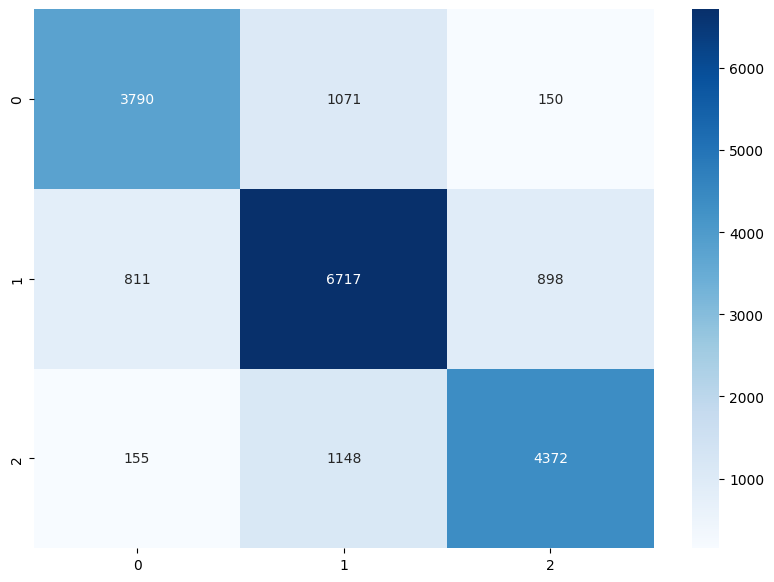

In [30]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

#### CatBoost Time!

In [31]:
from catboost import CatBoostClassifier


In [37]:
best_config = results_df.iloc[0]['config']

clf = CatBoostClassifier(iterations=10000)

train_fs = np.hstack([train[fs_type] for fs_type in best_config])
test_fs = np.hstack([test[fs_type] for fs_type in best_config])

clf.fit(train_fs, y_train, silent=True)

In [38]:
y_pred_test = clf.predict(test_fs)
y_pred_train = clf.predict(train_fs)

print("test report")
print(classification_report(y_test, y_pred_test))

print("train report")
print(classification_report(y_train, y_pred_train))

test report
              precision    recall  f1-score   support

          -1       0.67      0.44      0.53      5011
           0       0.60      0.78      0.68      8426
           1       0.64      0.53      0.58      5675

    accuracy                           0.62     19112
   macro avg       0.63      0.59      0.60     19112
weighted avg       0.63      0.62      0.61     19112

train report
              precision    recall  f1-score   support

          -1       0.78      0.55      0.65     27789
           0       0.66      0.84      0.74     47954
           1       0.74      0.64      0.69     32555

    accuracy                           0.71    108298
   macro avg       0.73      0.68      0.69    108298
weighted avg       0.72      0.71      0.70    108298

